In [7]:
pip install catboost

In [10]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
from google.colab import drive
drive.mount('/content/gdirve/')

Drive already mounted at /content/gdirve/; to attempt to forcibly remount, call drive.mount("/content/gdirve/", force_remount=True).


# Data Load

In [12]:
def Load_Dataframe(path, genome_list):
  df = pd.DataFrame() # 암 데이터를 합쳐서 출력 받을 최종 df

  path_list= os.listdir(path) # 압축해제된 파일 경로
  for idx, f in enumerate(path_list):
    genome = genome_list[idx] # 불러올 암 이름 입력 받기
    genome_file = os.listdir(f'{path}/{genome}/') # 해당 암의 폴더로 들어가기
    txt = ''.join([i for i in genome_file if str(genome)in i]) # 필요한 파일만 출력
    # 파일 불러오기
    data = pd.read_csv(f'{path}/{genome}/{txt}', sep='\t', low_memory=False, index_col='Hybridization REF', skiprows=[1])
    data = data.transpose()
    #데이터 라벨링
    data['Target'] = data.index.str[13:15]
    data['Target'] = data['Target'].replace({'01':'Tumor', '02':'Tumor', '11':'Normal', '10':'Normal'})
    data['Target'] = genome +'_'+ data['Target']
    df = pd.concat([df, data])
    
  return df

In [13]:
path = '/content/gdirve/MyDrive/genome_data' # load할 데이터 경로
genome_list = ['LUAD', 'LUSC'] #입력 받는 암 데이터 명
df = Load_Dataframe(path, genome_list)

In [14]:
df

Hybridization REF,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932,Target
TCGA-05-4244-01A-01R-1107-07,0.0,10.0113,11.2820,49.5994,848.9397,0.0,345.2308,1.0472,0.0000,0.0,...,292.5212,959.2460,0.6981,1088.0531,2837.9440,871.2802,575.2683,6.6323,0.0000,LUAD_Tumor
TCGA-05-4249-01A-01R-1107-07,0.0,7.1957,12.4436,90.5117,924.0158,0.0,145.2025,1.6098,0.0000,0.0,...,493.5597,1179.3275,20.2833,787.5061,2351.2500,1138.1170,690.2752,179.9738,0.0000,LUAD_Tumor
TCGA-05-4250-01A-01R-1107-07,0.0,7.2453,6.0184,49.5366,1140.6781,0.0,51.7284,0.0000,0.0000,0.0,...,365.4149,843.9028,26.5274,475.1720,5437.4534,1170.5214,532.8691,6.3003,0.0000,LUAD_Tumor
TCGA-05-4382-01A-01R-1206-07,0.0,11.3311,7.5740,82.8303,807.1729,0.0,240.0221,0.4786,0.2393,0.0,...,346.7517,946.6872,64.8514,908.1593,6770.1537,1169.2401,663.8297,35.1777,0.0000,LUAD_Tumor
TCGA-05-4384-01A-01R-1755-07,0.0,3.2254,3.4942,72.5351,562.0037,0.0,274.2822,0.6109,0.0000,0.0,...,563.2254,1320.7086,7.9414,778.8638,3341.4783,1737.3244,723.2743,378.1307,0.0000,LUAD_Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-O2-A52S-01A-11R-A262-07,0.0,19.9503,47.1026,176.7177,1188.3278,0.0,226.8212,1.6556,0.0000,0.0,...,507.4503,1392.7980,126.2417,580.2980,2681.7053,1069.5364,783.1126,5.3808,1.2417,LUSC_Tumor
TCGA-O2-A52V-01A-31R-A262-07,0.0,30.0872,15.2957,188.7215,1248.0303,0.0,147.4945,0.4202,0.0000,0.0,...,366.8453,1326.6099,6.3032,845.8872,6094.3376,663.9353,778.6532,2.1011,0.0000,LUSC_Tumor
TCGA-O2-A52W-01A-11R-A26W-07,0.0,53.6593,33.3907,260.3332,789.3606,0.0,854.3794,0.0000,0.0000,0.0,...,336.9156,2002.6867,101.5583,613.6486,2560.9887,730.2526,761.9559,12.3589,0.0000,LUSC_Tumor
TCGA-O2-A5IB-01A-11R-A27Q-07,0.0,72.5666,42.1832,160.1624,460.8626,0.0,569.2226,1.3312,0.0000,0.0,...,584.1321,2074.5474,150.4260,1155.2183,1185.0373,833.3333,1383.1203,1.0650,0.0000,LUSC_Tumor


# data labeling

In [18]:
for i in df['Target'].unique():
  print(f'{i} :', len(df[df['Target'] == i]))

LUAD_Tumor : 517
LUAD_Normal : 59
LUSC_Tumor : 501
LUSC_Normal : 51


In [19]:
tumorDf = df[df['Target'].str[-5:] == 'Tumor']
tumorDf['Target'].unique()

array(['LUAD_Tumor', 'LUSC_Tumor'], dtype=object)

In [20]:
tumorDf.iloc[:,-1:]

Hybridization REF,Target
TCGA-05-4244-01A-01R-1107-07,LUAD_Tumor
TCGA-05-4249-01A-01R-1107-07,LUAD_Tumor
TCGA-05-4250-01A-01R-1107-07,LUAD_Tumor
TCGA-05-4382-01A-01R-1206-07,LUAD_Tumor
TCGA-05-4384-01A-01R-1755-07,LUAD_Tumor
...,...
TCGA-O2-A52S-01A-11R-A262-07,LUSC_Tumor
TCGA-O2-A52V-01A-31R-A262-07,LUSC_Tumor
TCGA-O2-A52W-01A-11R-A26W-07,LUSC_Tumor
TCGA-O2-A5IB-01A-11R-A27Q-07,LUSC_Tumor


In [21]:
tumorDf = pd.get_dummies(tumorDf, columns=['Target'], drop_first=True)
tumorDf.rename(columns = {'Target_LUSC_Tumor':'LUSC'}, inplace=True)
tumorDf.iloc[:,-1:]

,LUSC
TCGA-05-4244-01A-01R-1107-07,0
TCGA-05-4249-01A-01R-1107-07,0
TCGA-05-4250-01A-01R-1107-07,0
TCGA-05-4382-01A-01R-1206-07,0
TCGA-05-4384-01A-01R-1755-07,0
...,...
TCGA-O2-A52S-01A-11R-A262-07,1
TCGA-O2-A52V-01A-31R-A262-07,1
TCGA-O2-A52W-01A-11R-A26W-07,1
TCGA-O2-A5IB-01A-11R-A27Q-07,1


# CatBoost Classifier 

In [22]:
data = tumorDf.iloc[:,:-1]
target = tumorDf['LUSC']

# train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=20) #stratufy 옵션을 통해 class 비율 유지
print(f'train: {x_train.shape}, {y_train.shape} test: {x_test.shape}, {y_test.shape}\n')
print("training label 빈도:\n", pd.DataFrame(y_train).value_counts(), sep="", end="\n\n")
print("test label 빈도:\n", pd.DataFrame(y_test).value_counts(), sep="")

train: (814, 20531), (814,) test: (204, 20531), (204,)

training label 빈도:
LUSC
0       413
1       401
dtype: int64

test label 빈도:
LUSC
0       104
1       100
dtype: int64


In [23]:
# 최적의 파라미터 찾기
clf = CatBoostClassifier(task_type='GPU', border_count=None)

params = {'iterations': [600, 800, 1000],
          'depth': [4, 5, 6],
          'loss_function': ['MultiClass'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [10],
           'eval_metric': ['Accuracy'],
          'logging_level':['Silent'],
          'random_seed': [20]
         }
clf_grid = GridSearchCV(estimator=clf, param_grid=params, cv=2, refit=True) #refit 설정으로 최적 파라미터 저장
clf_grid.fit(x_train, y_train)

scores_df = pd.DataFrame(clf_grid.cv_results_)
# score 결과값 특정 칼럼들만 가져오기 
scores_df[['params', 'mean_test_score', 'rank_test_score', 
           'split0_test_score', 'split1_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score
0,"{'depth': 4, 'eval_metric': 'Accuracy', 'itera...",0.945946,14,0.941032,0.950860
1,"{'depth': 4, 'eval_metric': 'Accuracy', 'itera...",0.945946,14,0.941032,0.950860
2,"{'depth': 4, 'eval_metric': 'Accuracy', 'itera...",0.945946,14,0.941032,0.950860
3,"{'depth': 4, 'eval_metric': 'Accuracy', 'itera...",0.944717,19,0.938575,0.950860
4,"{'depth': 4, 'eval_metric': 'Accuracy', 'itera...",0.944717,19,0.938575,0.950860
5,"{'depth': 4, 'eval_metric': 'Accuracy', 'itera...",0.944717,19,0.938575,0.950860
6,"{'depth': 4, 'eval_metric': 'Accuracy', 'itera...",0.943489,25,0.936118,0.950860
7,"{'depth': 4, 'eval_metric': 'Accuracy', 'itera...",0.943489,25,0.936118,0.950860
8,"{'depth': 4, 'eval_metric': 'Accuracy', 'itera...",0.943489,25,0.936118,0.950860
9,"{'depth': 5, 'eval_metric': 'Accuracy', 'itera...",0.947174,3,0.941032,0.953317


In [24]:
# 최적의 파라미터는 best_params_에 할당
print(f"최적의 파라미터 : {clf_grid.best_params_}")
print(f"최적의 파라미터로 모델의 정확도 : {clf_grid.best_score_}")

최적의 파라미터 : {'depth': 5, 'eval_metric': 'Accuracy', 'iterations': 600, 'l2_leaf_reg': 3.162277660168379e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'MultiClass', 'random_seed': 20}
최적의 파라미터로 모델의 정확도 : 0.9484029484029484


In [25]:
# 최적의 파라미터로 학습되어 있는 모델링 할당
clf_model = clf_grid.best_estimator_
#정확도 비교
pred_y = clf_model.predict(x_test)
print(f"실제값과 예측값 정확도 : {accuracy_score(y_test, pred_y)}")

실제값과 예측값 정확도 : 0.9607843137254902


# Feature importance

In [99]:
# 유전자 중요도 출력
clf_importances = clf_model.feature_importances_
# 중요도 높은 순서 인덱스
sorted_idx = clf_importances.argsort()[::-1] 
clf_importances[sorted_idx]
topDf = pd.DataFrame(clf_importances[sorted_idx], index=x_train.columns[sorted_idx], columns=['Top Biomarker']).iloc[:10]
topDf

,Top Biomarker
RAB19|401409,5.667101
DSC3|1825,4.459259
CALML3|810,4.402560
TMED5|50999,3.875507
KRT5|3852,2.743065
ELFN2|114794,2.599578
SPRR2E|6704,2.211740
C20orf30|29058,1.970628
ZNF639|51193,1.716403
ZNF385B|151126,1.576041


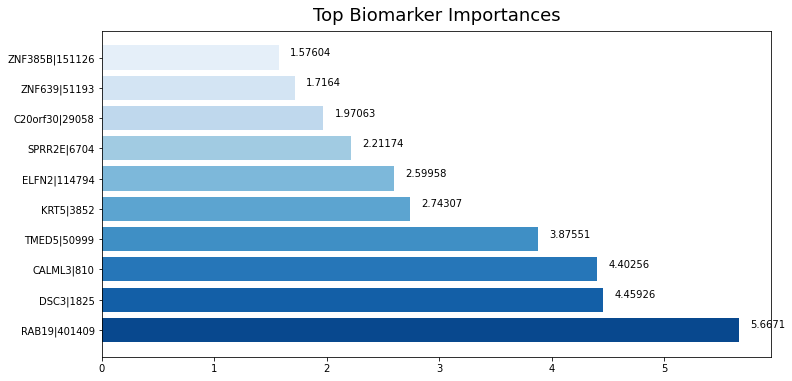

In [100]:
fig, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette('Blues_r', len(topDf))
bar = plt.barh(topDf.index, topDf['Top Biomarker'], color=colors)
ax.set_title("Top Biomarker Importances", pad=10, fontsize=18)
ax.set_yticklabels(topDf.index, fontsize=10)
for idx, b in enumerate(bar):
    y = b.get_width()
    ax.text(y+0.1, idx, round(y,5), va='bottom', fontsize=10)
plt.show()

# Cancer Patients Comparison

In [105]:
# 20개의 환자만 출력해서 비교하기
final_Clf = tumorDf[topDf.index]
cancer_sample = final_Clf.sample(n=20)
cancer_sample.shape

(20, 10)

In [108]:
tumorDf.loc[cancer_sample.index,'LUSC'].sort_values()

TCGA-95-7567-01A-11R-2066-07    0
TCGA-97-8547-01A-11R-2403-07    0
TCGA-44-A47B-01A-11R-A24H-07    0
TCGA-55-6968-01A-11R-1949-07    0
TCGA-69-8453-01A-12R-2326-07    0
TCGA-44-3398-01A-01R-1107-07    0
TCGA-55-6642-01A-11R-1858-07    0
TCGA-L4-A4E6-01A-11R-A24H-07    0
TCGA-62-A471-01A-12R-A24H-07    0
TCGA-64-5781-01A-01R-1628-07    0
TCGA-NK-A5CT-01A-31R-A26W-07    1
TCGA-66-2770-01A-01R-0851-07    1
TCGA-39-5016-01A-01R-1443-07    1
TCGA-O2-A52Q-01A-11R-A26W-07    1
TCGA-60-2724-01A-01R-0851-07    1
TCGA-21-5784-01A-01R-1635-07    1
TCGA-22-5477-01A-01R-1635-07    1
TCGA-90-A4EE-01A-11R-A24Z-07    1
TCGA-56-7222-01A-11R-2045-07    1
TCGA-56-8305-01A-11R-2296-07    1
Name: LUSC, dtype: uint8

In [114]:
cancer_idx = tumorDf.loc[cancer_sample.index,'LUSC'].sort_values().index 
final_Clf.loc[cancer_idx].head()

,RAB19|401409,DSC3|1825,CALML3|810,TMED5|50999,KRT5|3852,ELFN2|114794,SPRR2E|6704,C20orf30|29058,ZNF639|51193,ZNF385B|151126
TCGA-95-7567-01A-11R-2066-07,32.6301,1.6878,1.4065,1640.2138,10.9705,2254.8523,0.2813,1808.4388,632.3488,9.2827
TCGA-97-8547-01A-11R-2403-07,16.0866,12.2565,2.2981,870.9740,9.1923,1203.4303,0.0000,2104.2794,343.1806,29.1091
TCGA-44-A47B-01A-11R-A24H-07,7.1652,0.4478,0.0000,1972.6825,3.1348,1152.2615,4.0305,2357.3668,519.4805,98.0743
TCGA-55-6968-01A-11R-1949-07,16.0275,53.2341,146.5369,2342.2839,91.5856,2.8620,30.9101,2840.2977,887.8077,38.9239
TCGA-69-8453-01A-12R-2326-07,10.7212,39.4737,7.3099,1655.9454,814.3275,347.4659,0.0000,2000.4873,385.4776,480.0195


In [121]:
final_Clf.loc[cancer_idx].describe()

,RAB19|401409,DSC3|1825,CALML3|810,TMED5|50999,KRT5|3852,ELFN2|114794,SPRR2E|6704,C20orf30|29058,ZNF639|51193,ZNF385B|151126
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,10.158315,2848.736780,5418.412395,1690.176655,53415.360960,335.118295,391.151845,3005.894450,974.568650,122.137680
std,8.854331,4103.279652,10369.732669,669.613340,75005.133728,581.447689,809.270116,1043.269422,747.255009,224.063572
min,1.036300,0.447800,0.000000,716.662300,3.134800,2.142900,0.000000,1749.492900,343.180600,0.000000
25%,2.611800,11.119575,2.075200,1102.855000,10.685275,15.530150,0.000000,2078.331375,503.434550,24.289225
50%,8.046900,226.929050,82.244150,1648.079600,4545.271150,91.671750,4.112400,2782.311000,739.891650,39.104800
75%,16.042275,6004.664225,5411.864275,2149.773975,88901.001625,287.052875,59.667300,4045.645700,1146.723100,105.514150
max,32.630100,12887.448800,41695.897400,3463.383300,232738.692900,2254.852300,2530.087900,5200.000000,3610.345700,946.638900


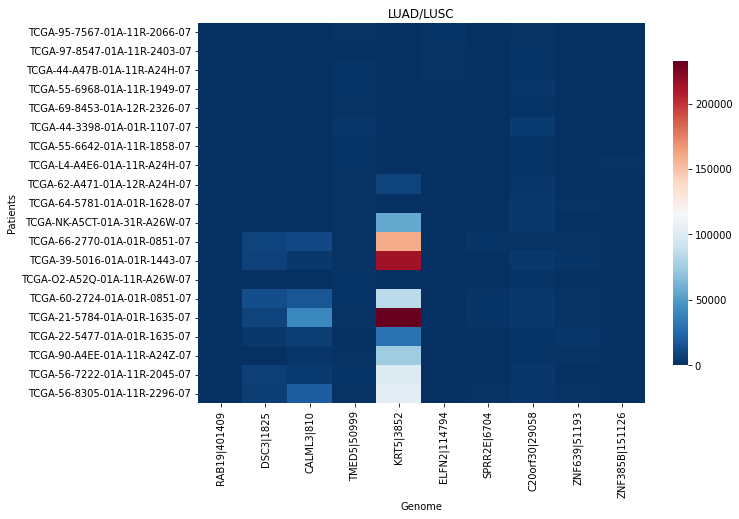

In [128]:
fig, ax = plt.subplots(figsize=(10,7))

sns.heatmap(final_Clf.loc[cancer_idx],
            cmap = 'RdBu_r',
            cbar_kws = {"shrink": .8}
            )
ax.set_xlabel('Genome')
ax.set_ylabel('Patients')
ax.set_title('LUAD/LUSC')

plt.show()